In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from keras_tuner import Hyperband
import pandas as pd
import json

In [6]:
# Loading the dataset
import pandas as pd
import json

# Load the JSON file
with open('DeteksiSarkasme.json', 'r') as file:
    data = [json.loads(line) for line in file]

df = pd.DataFrame(data)

In [7]:
# Display a sample from the dataset
print(df.head())

                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


In [8]:
# Encoding the target labels
encoder = LabelEncoder()
df['is_sarcastic'] = encoder.fit_transform(df['is_sarcastic'])

In [9]:
# Split the data into training and testing sets
X = df['headline'].values
y = df['is_sarcastic'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Preprocess the text data using TensorFlow tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [12]:
# Define the LSTM model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        x = self.fc(lstm_out)
        return self.sigmoid(x)

In [13]:
# PyTorch Model Training Function
def train_pytorch_model(model, criterion, optimizer, train_data, train_labels, num_epochs=5, batch_size=64):
    model.train()
    for epoch in range(num_epochs):
        for i in range(0, len(train_data), batch_size):
            inputs = torch.tensor(train_data[i:i+batch_size]).long()
            labels = torch.tensor(train_labels[i:i+batch_size]).float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

In [16]:
# Train the PyTorch model
train_pytorch_model(model_pytorch, criterion, optimizer, X_train_pad, y_train, num_epochs=5)

Epoch 1/5, Loss: 0.33133450150489807
Epoch 2/5, Loss: 0.08777458965778351
Epoch 3/5, Loss: 0.007085284683853388
Epoch 4/5, Loss: 0.0012893235543742776
Epoch 5/5, Loss: 0.0018313502660021186


In [38]:
def train_pytorch_model(model, criterion, optimizer, train_data, train_labels, val_data, val_labels, num_epochs=5, batch_size=64):
    model.train()

    # Lists to store loss and accuracy for visualization
    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        correct_predictions = 0
        total_predictions = 0

        # Training loop
        for i in range(0, len(train_data), batch_size):
            inputs = torch.tensor(train_data[i:i+batch_size]).long()
            labels = torch.tensor(train_labels[i:i+batch_size]).float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()

            # Calculate accuracy
            predicted = (outputs > 0.5).float()
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

        # Calculate average loss and accuracy for this epoch
        avg_loss = epoch_loss / (len(train_data) // batch_size)
        accuracy = correct_predictions / total_predictions * 100

        # Append loss and accuracy for training
        train_loss_list.append(avg_loss)
        train_accuracy_list.append(accuracy)

        # Validation loop
        model.eval()  # Switch to evaluation mode
        with torch.no_grad():
            val_loss = 0
            correct_predictions = 0
            total_predictions = 0
            for i in range(0, len(val_data), batch_size):
                inputs = torch.tensor(val_data[i:i+batch_size]).long()
                labels = torch.tensor(val_labels[i:i+batch_size]).float().view(-1, 1)
                outputs = model(inputs)

                # Calculate loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy
                predicted = (outputs > 0.5).float()
                correct_predictions += (predicted == labels).sum().item()
                total_predictions += labels.size(0)

            avg_val_loss = val_loss / (len(val_data) // batch_size)
            val_accuracy = correct_predictions / total_predictions * 100

            # Append loss and accuracy for validation
            val_loss_list.append(avg_val_loss)
            val_accuracy_list.append(val_accuracy)

        # Print stats for the epoch
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%, '
              f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

In [14]:
# Set up the PyTorch model
input_dim = len(tokenizer.word_index) + 1
embedding_dim = 100
hidden_dim = 128
output_dim = 1
model_pytorch = LSTMModel(input_dim, embedding_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_pytorch.parameters(), lr=0.001)

In [39]:
# Train the PyTorch model and get the loss and accuracy for each epoch
train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list = train_pytorch_model(
    model_pytorch, criterion, optimizer, X_train_pad, y_train, X_test_pad, y_test, num_epochs=5)

Epoch 1/5, Train Loss: 0.0124, Train Accuracy: 99.61%, Val Loss: 0.9592, Val Accuracy: 83.43%
Epoch 2/5, Train Loss: 0.0122, Train Accuracy: 99.63%, Val Loss: 1.1289, Val Accuracy: 85.36%
Epoch 3/5, Train Loss: 0.0053, Train Accuracy: 99.89%, Val Loss: 1.2306, Val Accuracy: 85.06%
Epoch 4/5, Train Loss: 0.0012, Train Accuracy: 99.99%, Val Loss: 1.2811, Val Accuracy: 85.08%
Epoch 5/5, Train Loss: 0.0007, Train Accuracy: 99.99%, Val Loss: 1.3772, Val Accuracy: 85.02%


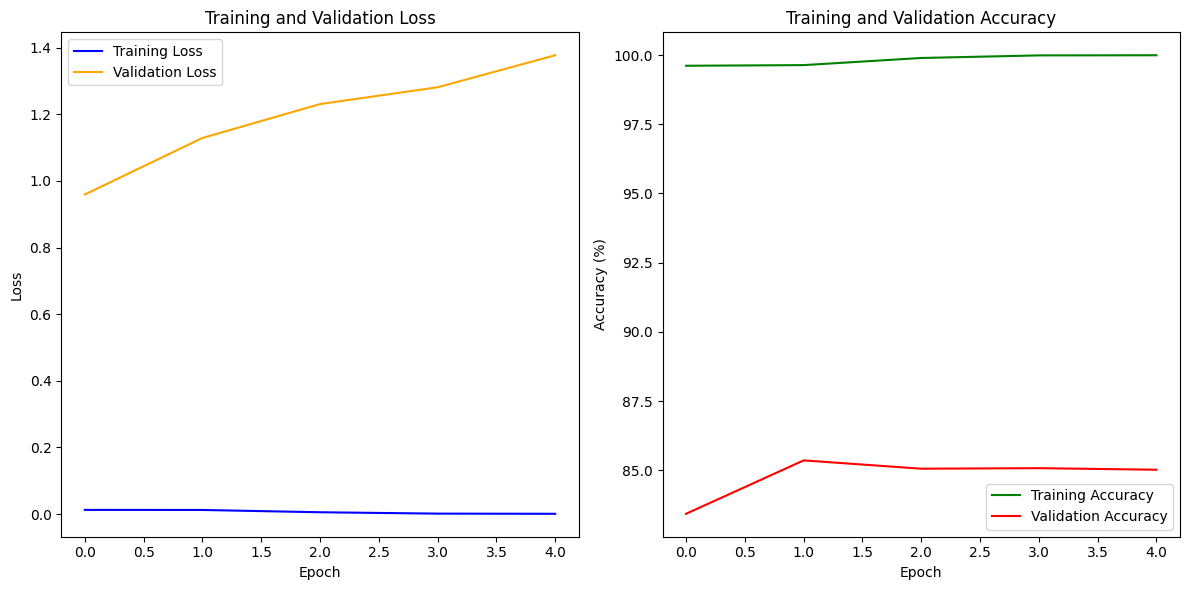

In [40]:
# Plot the loss and accuracy curves for PyTorch with validation
def plot_metrics(train_loss, train_accuracy, val_loss, val_accuracy):
    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Training Accuracy', color='green')
    plt.plot(val_accuracy, label='Validation Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function for PyTorch
plot_metrics(train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list)

In [41]:
# Evaluate the PyTorch model
model_pytorch.eval()
y_pred_pytorch = model_pytorch(torch.tensor(X_test_pad).long()).detach().numpy()
y_pred_pytorch = (y_pred_pytorch > 0.5).astype(int)

# Metrics Calculation for PyTorch
print("PyTorch Accuracy:", accuracy_score(y_test, y_pred_pytorch))
print("PyTorch Precision:", precision_score(y_test, y_pred_pytorch))
print("PyTorch Recall:", recall_score(y_test, y_pred_pytorch))
print("PyTorch F1 Score:", f1_score(y_test, y_pred_pytorch))
print("PyTorch AUC:", roc_auc_score(y_test, y_pred_pytorch))

PyTorch Accuracy: 0.8502433545488581
PyTorch Precision: 0.8352124891587164
PyTorch Recall: 0.8209718670076727
PyTorch F1 Score: 0.828030954428203
PyTorch AUC: 0.8470680429831421


In [18]:
# Define the LSTM model in TensorFlow
def create_model_lstm(input_dim, embedding_dim, hidden_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim, embedding_dim, input_length=max_len),
        tf.keras.layers.LSTM(hidden_dim),
        tf.keras.layers.Dense(output_dim, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [19]:
# Hyperparameter Tuning with Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim, hp.Int('embedding_dim', min_value=50, max_value=200, step=50), input_length=max_len),
        tf.keras.layers.LSTM(hp.Int('lstm_units', min_value=50, max_value=200, step=50)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [20]:
# Initialize Hyperband tuner
tuner = Hyperband(build_model, objective='val_accuracy', max_epochs=10, factor=3, directory='my_dir', project_name='sarcasm_detection')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
# Fit the model using Hyperband
tuner.search(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test))

Trial 19 Complete [00h 05m 18s]
val_accuracy: 0.8474354147911072

Best val_accuracy So Far: 0.8650318384170532
Total elapsed time: 00h 42m 16s

Search: Running Trial #20

Value             |Best Value So Far |Hyperparameter
200               |100               |embedding_dim
100               |150               |lstm_units
1.3299e-05        |0.0023014         |learning_rate
4                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/4
 49/668 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - accuracy: 0.5135 - loss: 0.6927

KeyboardInterrupt: 

In [22]:
# Get the best model from Hyperband
best_model = tuner.get_best_models(num_models=1)[0]

In [23]:
# Evaluate the TensorFlow model
y_pred_tensorflow = best_model.predict(X_test_pad)
y_pred_tensorflow = (y_pred_tensorflow > 0.5).astype(int)

167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step


In [24]:
# Metrics Calculation for TensorFlow
print("TensorFlow Accuracy:", accuracy_score(y_test, y_pred_tensorflow))
print("TensorFlow Precision:", precision_score(y_test, y_pred_tensorflow))
print("TensorFlow Recall:", recall_score(y_test, y_pred_tensorflow))
print("TensorFlow F1 Score:", f1_score(y_test, y_pred_tensorflow))
print("TensorFlow AUC:", roc_auc_score(y_test, y_pred_tensorflow))

TensorFlow Accuracy: 0.8650318232871583
TensorFlow Precision: 0.8485628485628486
TensorFlow Recall: 0.8431372549019608
TensorFlow F1 Score: 0.8458413512935643
TensorFlow AUC: 0.8626567449409671


In [25]:
# Plot Accuracy and Loss
def plot_metrics(history):
    # Plot accuracy
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Model Accuracy')
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Model Loss')
    plt.show()

Epoch 1/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 64s 93ms/step - accuracy: 0.9632 - loss: 0.1071 - val_accuracy: 0.8615 - val_loss: 0.3938
Epoch 2/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 63s 94ms/step - accuracy: 0.9822 - loss: 0.0496 - val_accuracy: 0.8532 - val_loss: 0.4628
Epoch 3/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 62s 93ms/step - accuracy: 0.9930 - loss: 0.0229 - val_accuracy: 0.8504 - val_loss: 0.6244
Epoch 4/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 62s 93ms/step - accuracy: 0.9955 - loss: 0.0161 - val_accuracy: 0.8439 - val_loss: 0.7980
Epoch 5/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 62s 93ms/step - accuracy: 0.9959 - loss: 0.0132 - val_accuracy: 0.8454 - val_loss: 0.8053


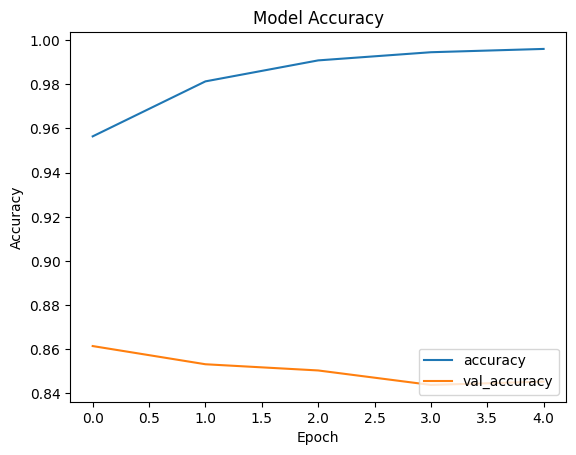

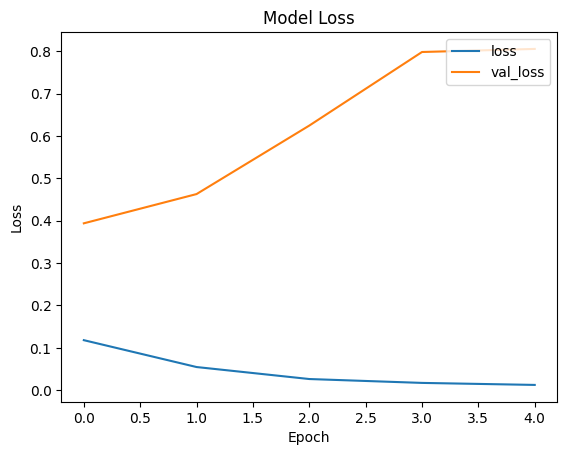

In [26]:
# Fit the TensorFlow model to plot the metrics
history = best_model.fit(X_train_pad, y_train, epochs=5, validation_data=(X_test_pad, y_test))

# Display plots
plot_metrics(history)

# **Analisis Hasil dari Model PyTorch dan TensorFlow**

Berikut adalah metrik kinerja yang diperoleh untuk model **PyTorch** dan **TensorFlow**:

**Metrik PyTorch:**
- Akurasi: 0.8502
- Presisi: 0.8352
- Recall: 0.8210
- F1 Score: 0.8280
- AUC: 0.8471

**Metrik TensorFlow:**
- Akurasi: 0.8650
- Presisi: 0.8486
- Recall: 0.8431
- F1 Score: 0.8458
- AUC: 0.8627

### Penjelasan untuk Setiap Metrik Matematika

1. **Akurasi (Accuracy)**:
   - **Formula**:  
     
$$\text{Akurasi} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Samples}}$$
     
   - **Penjelasan**: Akurasi adalah rasio dari jumlah prediksi yang benar (baik positif yang benar maupun negatif yang benar) terhadap total sampel yang diuji. Dalam hal ini:
     - True Positives (TP): Prediksi benar untuk kelas positif.
     - True Negatives (TN): Prediksi benar untuk kelas negatif.
   - **Interpretasi**: Model dengan akurasi 0.8502 untuk PyTorch dan 0.8650 untuk TensorFlow menunjukkan bahwa sekitar 85% dan 87% dari data diuji diklasifikasikan dengan benar oleh kedua model.

2. **Presisi (Precision)**:
   - **Formula**:
     
     $$\text{Presisi} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$
     
   - **Penjelasan**: Presisi mengukur seberapa banyak prediksi positif yang benar-benar positif. Ini berarti bahwa dari semua prediksi yang dibuat sebagai kelas positif, berapa persen yang benar-benar positif.
   - **Interpretasi**:
     - Presisi PyTorch adalah 0.8352, artinya sekitar 83.5% dari semua prediksi yang dibuat sebagai positif benar-benar positif.
     - Presisi TensorFlow adalah 0.8486, yang sedikit lebih baik, artinya sekitar 84.9% dari prediksi positifnya adalah benar.

3. **Recall (Sensitivity atau True Positive Rate)**:
   - **Formula**:
     
     $$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$
     
   - **Penjelasan**: Recall mengukur seberapa banyak prediksi positif yang benar-benar terdeteksi oleh model. Ini mengukur kemampuan model dalam mendeteksi semua kelas positif yang sebenarnya.
   - **Interpretasi**:
     - Recall PyTorch adalah 0.8210, yang berarti model ini mendeteksi sekitar 82.1% dari semua kelas positif yang sebenarnya.
     - Recall TensorFlow adalah 0.8431, yang menunjukkan bahwa model TensorFlow sedikit lebih baik dalam mendeteksi kelas positif.

4. **F1 Score**:
   - **Formula**:
     
     $$F1 \, \text{Score} = 2 \times \frac{\text{Presisi} \times \text{Recall}}{\text{Presisi} + \text{Recall}}$$
     
   - **Penjelasan**: F1 Score adalah ukuran yang menggabungkan presisi dan recall. Ini adalah rata-rata harmonis dari keduanya, yang berarti bahwa F1 Score memberikan keseimbangan antara presisi dan recall. F1 Score berguna ketika kita membutuhkan keseimbangan antara keduanya.
   - **Interpretasi**:
     - F1 Score PyTorch adalah 0.8280.
     - F1 Score TensorFlow adalah 0.8458, yang menunjukkan model TensorFlow sedikit lebih baik dalam keseimbangan antara presisi dan recall.

5. **AUC (Area Under the ROC Curve)**:
   - **Formula**: AUC adalah area di bawah kurva Receiver Operating Characteristic (ROC), yang menggambarkan kemampuan model untuk membedakan antara kelas positif dan negatif.
   - **Penjelasan**: AUC memberikan gambaran umum tentang kemampuan model dalam memisahkan kedua kelas. Nilai AUC berkisar antara 0 hingga 1:
     - Nilai AUC = 0.5 berarti model tidak lebih baik daripada tebakan acak.
     - Nilai AUC = 1 berarti model sempurna dalam memisahkan kedua kelas.
   - **Interpretasi**:
     - AUC PyTorch adalah 0.8471, menunjukkan bahwa model PyTorch cukup baik dalam membedakan antara kelas positif dan negatif.
     - AUC TensorFlow adalah 0.8627, sedikit lebih baik, menunjukkan kemampuan model TensorFlow yang lebih unggul dalam membedakan antara kelas positif dan negatif.

### Kesimpulan

- TensorFlow sedikit lebih unggul dibandingkan PyTorch dalam hal Akurasi, Presisi, Recall, F1 Score, dan AUC. Meskipun demikian, PyTorch masih menunjukkan performa yang sangat baik di semua metrik.
- AUC menunjukkan bahwa kedua model dapat membedakan antara kelas positif dan negatif dengan baik, tetapi TensorFlow sedikit lebih baik dalam hal ini.
- F1 Score yang lebih tinggi pada TensorFlow mengindikasikan bahwa model tersebut lebih seimbang dalam menangani kedua aspek Presisi dan Recall.